In [3]:
from pathlib import Path
from tqdm.notebook import tqdm
import librosa
import librosa.display
import numpy as np
import soundfile
import pandas as pd
import joblib
import tensorflow as tf
import tensorflow.keras as keras


import random
import os

## Parameters
Let's introduce a few convenience variables.

In [4]:
SR = 32_000
DURATION = 5
SEED = 42

In [5]:
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)

seed_everything()

In [6]:
PATH_DATASET = Path.home() / "datasets/kaggle/birdclef-2021"
PATH_DATASET.exists()

True

In [7]:
L_birds = [path.name for path
           in (PATH_DATASET / "train_short_audio").iterdir()]
L_birds[:10]

['acafly',
 'acowoo',
 'aldfly',
 'ameavo',
 'amecro',
 'amegfi',
 'amekes',
 'amepip',
 'amered',
 'amerob']

In [8]:
sorted(L_birds) == L_birds

True

In [9]:
D_label_index = {label: i for i, label in enumerate(L_birds)}
D_label_index

{'acafly': 0,
 'acowoo': 1,
 'aldfly': 2,
 'ameavo': 3,
 'amecro': 4,
 'amegfi': 5,
 'amekes': 6,
 'amepip': 7,
 'amered': 8,
 'amerob': 9,
 'amewig': 10,
 'amtspa': 11,
 'andsol1': 12,
 'annhum': 13,
 'astfly': 14,
 'azaspi1': 15,
 'babwar': 16,
 'baleag': 17,
 'balori': 18,
 'banana': 19,
 'banswa': 20,
 'banwre1': 21,
 'barant1': 22,
 'barswa': 23,
 'batpig1': 24,
 'bawswa1': 25,
 'bawwar': 26,
 'baywre1': 27,
 'bbwduc': 28,
 'bcnher': 29,
 'belkin1': 30,
 'belvir': 31,
 'bewwre': 32,
 'bkbmag1': 33,
 'bkbplo': 34,
 'bkbwar': 35,
 'bkcchi': 36,
 'bkhgro': 37,
 'bkmtou1': 38,
 'bknsti': 39,
 'blbgra1': 40,
 'blbthr1': 41,
 'blcjay1': 42,
 'blctan1': 43,
 'blhpar1': 44,
 'blkpho': 45,
 'blsspa1': 46,
 'blugrb1': 47,
 'blujay': 48,
 'bncfly': 49,
 'bnhcow': 50,
 'bobfly1': 51,
 'bongul': 52,
 'botgra': 53,
 'brbmot1': 54,
 'brbsol1': 55,
 'brcvir1': 56,
 'brebla': 57,
 'brncre': 58,
 'brnjay': 59,
 'brnthr': 60,
 'brratt1': 61,
 'brwhaw': 62,
 'brwpar1': 63,
 'btbwar': 64,
 'btnwar': 6

In [10]:
D_index_label = {v: k for k, v in D_label_index.items()}
D_index_label

{0: 'acafly',
 1: 'acowoo',
 2: 'aldfly',
 3: 'ameavo',
 4: 'amecro',
 5: 'amegfi',
 6: 'amekes',
 7: 'amepip',
 8: 'amered',
 9: 'amerob',
 10: 'amewig',
 11: 'amtspa',
 12: 'andsol1',
 13: 'annhum',
 14: 'astfly',
 15: 'azaspi1',
 16: 'babwar',
 17: 'baleag',
 18: 'balori',
 19: 'banana',
 20: 'banswa',
 21: 'banwre1',
 22: 'barant1',
 23: 'barswa',
 24: 'batpig1',
 25: 'bawswa1',
 26: 'bawwar',
 27: 'baywre1',
 28: 'bbwduc',
 29: 'bcnher',
 30: 'belkin1',
 31: 'belvir',
 32: 'bewwre',
 33: 'bkbmag1',
 34: 'bkbplo',
 35: 'bkbwar',
 36: 'bkcchi',
 37: 'bkhgro',
 38: 'bkmtou1',
 39: 'bknsti',
 40: 'blbgra1',
 41: 'blbthr1',
 42: 'blcjay1',
 43: 'blctan1',
 44: 'blhpar1',
 45: 'blkpho',
 46: 'blsspa1',
 47: 'blugrb1',
 48: 'blujay',
 49: 'bncfly',
 50: 'bnhcow',
 51: 'bobfly1',
 52: 'bongul',
 53: 'botgra',
 54: 'brbmot1',
 55: 'brbsol1',
 56: 'brcvir1',
 57: 'brebla',
 58: 'brncre',
 59: 'brnjay',
 60: 'brnthr',
 61: 'brratt1',
 62: 'brwhaw',
 63: 'brwpar1',
 64: 'btbwar',
 65: 'btnwar

In [11]:
df_train_soundscape = pd.read_csv("./rich_train_soundscape_labels.csv")
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds,is_test,year,month,day,longitude,latitude,npy_parent,npy_path
0,7019_COR_5,COR,7019,5,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_5.npy
1,7019_COR_10,COR,7019,10,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_10.npy
2,7019_COR_15,COR,7019,15,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_15.npy
3,7019_COR_20,COR,7019,20,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_20.npy
4,7019_COR_25,COR,7019,25,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_25.npy


In [14]:
L_useful_features = [
    #"longitude",
    "latitude",
    "month",
    "day",
    "is_test",
]
df_useful_features = df_train_soundscape.loc[:, L_useful_features]
df_useful_features

,latitude,month,day,is_test
0,10.12,9,4,True
1,10.12,9,4,True
2,10.12,9,4,True
3,10.12,9,4,True
4,10.12,9,4,True
...,...,...,...,...
2395,42.47,6,17,False
2396,42.47,6,17,False
2397,42.47,6,17,False
2398,42.47,6,17,False


## Melspectrogram
Let's study how to cut the audio files into pieces of 5 sec each and transform them into melspectrogram.

In [8]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):
        melspec = librosa.feature.melspectrogram(
            y,
            sr=self.sr,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax,
            **self.kwargs,
        )

        melspec = librosa.power_to_db(melspec).astype(np.float32)
        return melspec

In [9]:
def standardize_uint8(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    min_, max_ = X.min(), X.max()
    if max_ - min_ > eps:
        #V = np.clip(X, min_, max_)
        #V = 255 * (V - min_) / (max_ - min_)
        V = 255 * (X - min_) / (max_ - min_)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)
    return V

def crop_or_pad(y, length, is_train=True, start=None):
    """
    crop or pad the signal y to #(samples) = `length`
      - repetition of itself
      - random truncating
    """
    if len(y) < length:
        #y = np.concatenate([y, np.zeros(length - len(y))])
        n_repeats = length // len(y)
        remainder = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:remainder]])
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)
        y = y[start:start + length]
    return y

In [10]:
path_random_short_audio = random.choice(
    list((PATH_DATASET / "train_short_audio").glob("*/*.ogg"))
)
print(f"path_random_short_audio =\n{path_random_short_audio}")


# Excerpt from `class AudioToImage`
audio, orig_sr = soundfile.read(path_random_short_audio, dtype="float32")

if orig_sr != SR:
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")

audio = crop_or_pad(audio, length=SR*DURATION)
mel_spec_computer = MelSpecComputer(
    sr=SR,
    n_mels=128,
    fmin=0,
    fmax=None,
)
melspec = mel_spec_computer(audio) 
image = standardize_uint8(melspec)
type(image), image.shape

path_random_short_audio =
/home/phunc20/datasets/kaggle/birdclef-2021/train_short_audio/linwoo1/XC260614.ogg


(numpy.ndarray, (128, 201))

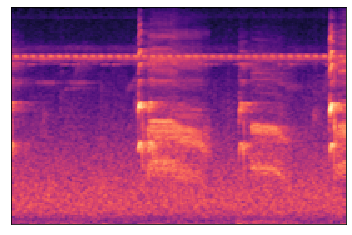

In [11]:
librosa.display.specshow(image);

These melspectrograms seem to be all single-channeled. Besides, probably due to the fact we have always taken the same number of samples (after resampling with a common `SR`), we always obtain an ndarray of shape `(128, 201)`.

## Statistics on `train_short_audio/`
I would like to know some statistics like

- How many `.ogg` files does each bird label have?
  - Linux's `tree` command might be able to answer to this question.
- How long are these `.ogg` files? Are some a lot longer than others?

Well, if we are to use `tree`, we'd be better off writing a whole shell script. Let's try it Python way.

In [18]:
D_label_nShort = dict()

In [19]:
for p in (PATH_DATASET / "train_short_audio").iterdir():
    n_oggs = len(set(p.iterdir()))
    #print(f"{p.name:12s}{n_oggs: 5d}")
    D_label_nShort[p.name] = n_oggs
D_label_nShort

acafly        132
acowoo        190
aldfly        227
ameavo         44
amecro        229
amegfi        181
amekes         82
amepip         98
amered        283
amerob        481
amewig         38
amtspa         80
andsol1       199
annhum        123
astfly        210
azaspi1       258
babwar         53
baleag         58
balori        155
banana        309
banswa        141
banwre1       103
barant1       198
barswa        500
batpig1        85
bawswa1        87
bawwar        153
baywre1       165
bbwduc        137
bcnher        334
belkin1        77
belvir        201
bewwre        466
bkbmag1        71
bkbplo        182
bkbwar        111
bkcchi        272
bkhgro        219
bkmtou1       153
bknsti        137
blbgra1       196
blbthr1       100
blcjay1        62
blctan1        35
blhpar1       159
blkpho        134
blsspa1       111
blugrb1       154
blujay        328
bncfly        406
bnhcow        177
bobfly1       236
bongul         53
botgra         84
brbmot1        81
brbsol1   

In [20]:
def duration(path_ogg):
    audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")
    return len(audio) / SR

The following cell can display the number of seconds each `.ogg` file lasts, but it's **time-consuming**; we'd better combine it with other loops for reading all the short audio files.
> But the result show that the duration is not quite homogeneous: it could range from as low as 6 seconds to sth like 200 seconds.

## `train_soundscapes/`

In [22]:
df_train_soundscape.notnull().all()

row_id      True
site        True
audio_id    True
seconds     True
birds       True
dtype: bool

There are a total of `20` `.ogg` files in `train_soundscapes/`: I would like to split these into train/val/test sets.

- `12` files for train
- `4` files for val
- `4` files for test

### Nota Bene
Just be careful: We decided to split the training data given by Kaggle into 3 parts -- train/val/test. So the word **`train`** in what follows may

- either means `train-train`
- or just `train`

Sorry for the confusion and the abuse, but unless I find time or I wouldn't correct it.

In [23]:
n_train = 12
n_val = 4     # Maybe I will put train and val together
n_test = 4

In [24]:
L_paths_train_soundscape = list((PATH_DATASET / "train_soundscapes").iterdir())
L_paths_train_soundscape

[PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/10534_SSW_20170429.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/11254_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/14473_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/18003_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/20152_SSW_20170805.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/21767_COR_20190904.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/26709_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/26746_COR_20191004.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/2782_SSW_20170701.ogg'),
 PosixPath('/home/phunc20/datasets/kaggle/birdclef-2021/train_soundscapes/28933_SSW_20170408.ogg'),
 

In [25]:
L_testSoundScapeIDs = [int(p.name.split("_")[0]) for p in L_paths_train_soundscape[-n_test:]]
S_testSoundScapeIDs = set(int(p.name.split("_")[0]) for p in L_paths_train_soundscape[-n_test:])
L_testSoundScapeIDs

[57610, 7019, 7843, 7954]

In [28]:
PATH_DATASET._str

'/home/phunc20/datasets/kaggle/birdclef-2021'

In [29]:
df_train_soundscape.dtypes

row_id      object
site        object
audio_id     int64
seconds      int64
birds       object
dtype: object

In [31]:
df_train_soundscape.audio_id.unique()

array([ 7019,  7954, 11254, 18003, 21767, 26746, 31928, 44957, 50878,
       57610,  2782,  7843, 10534, 14473, 20152, 26709, 28933, 42907,
       51010, 54955])

`mkdir` for places to store melspectrogram `.npy` files

In [36]:
trainSoundScapes = Path("./trainSoundScapes")
trainSoundScapes.exists()

True

In [38]:
testSoundScapes = Path("./testSoundScapes")
testSoundScapes.exists()

True

In [40]:
ls

01-data_exploration.ipynb   testSoundScapes/   trash.py
pandas_series_in_set.ipynb  trainSoundScapes/


`NamedTuple` and `itertuples()` method from dataframe

### Objectives: Save `.npy` Files
Let's make our objectives clear.

01. We want to save each `train_soundscapes/` audio file, each 5-sec clip, to an `.npy` file.
  - The file reading and melspectrogram transform might be quite blocking, so **asynchronous** or **multi-process** (e.g. `concurrent.futures.ProcessPoolExecutor` or `joblib`) programming might be useful here.
02. We want to update `df_train_soundscape` to contain more information. What information?
  - Date: Can be separated.
  - Corresponding `.npy` path: Can be separated.
  - Longitude, latitude: Can be separated.
  
Since the two objectives above can be separated, and updating an extra dataframe while saving `.npy` for each `.ogg` file can become quite complicated, let's first get objective 1 done and start objective 2 after that.

### Objective 1: `.ogg` to `.npy`

#### `joblib` way

In [46]:
S_trainSoundScapeIDs = set(int(p.name.split("_")[0]) for p in L_paths_train_soundscape[:-n_test])
S_trainSoundScapeIDs#, len(S_trainSoundScapeIDs)

{2782,
 10534,
 11254,
 14473,
 18003,
 20152,
 21767,
 26709,
 26746,
 28933,
 31928,
 42907,
 44957,
 50878,
 51010,
 54955}

In [50]:
def audio_to_mels(audio,
                  sr=SR,
                  n_mels=128,
                  fmin=0,
                  fmax=None):
    fmax = fmax or sr // 2
    mel_spec_computer = MelSpecComputer(sr=sr,
                                        n_mels=n_mels,
                                        fmin=fmin,
                                        fmax=fmax)
    mels = standardize_uint8(mel_spec_computer(audio))
    return mels

def every_5sec(id_,
               sr=SR,
               resample=True,
               res_type="kaiser_fast",
               single_process=True,
               save_to=Path("corbeille"),
               n_workers=2
                ):
    """
    - read the audio file of ID `id_`
    - cut the read audio into pieces of 5 seconds
    - convert each piece into `.npy` file and save
    """
    path_ogg = next((PATH_DATASET / "train_soundscapes").glob(f"{id_}*.ogg"))
    location = (path_ogg.name).split("_")[1]
    whole_audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    if resample and orig_sr != sr:
        whole_audio = librosa.resample(whole_audio, orig_sr, sr, res_type=res_type)
    n_samples = len(whole_audio)
    n_samples_5sec = sr * 5
    save_to.mkdir(exist_ok=True)

    def convert_and_save(i):
        audio_i = whole_audio[i:i + n_samples_5sec]
        mels_i = audio_to_mels(audio_i)
        path_i = save_to / f"{id_}_{location}_{((i + n_samples_5sec) // n_samples_5sec) * 5}.npy"
        np.save(str(path_i), mels_i)

    if single_process:
        for i in range(0, n_samples - n_samples % n_samples_5sec, n_samples_5sec):
            #audio_i = whole_audio[i:i + n_samples_5sec]
            ## No need the next check because in range() we have subtracted the remainder.
            ## That is, len(audio_i) is guaranteed to be n_samples_5sec for all i.
            ##if len(audio_i) < n_samples_5sec:
            ##    pass
            #mels_i = audio_to_mels(audio_i)
            #path_i = save_to / f"{id_}_{location}_{((i + n_samples_5sec) // n_samples_5sec) * 5}.npy"
            #np.save(str(path_i), mels_i)
            convert_and_save(i)
    else:
        pool = joblib.Parallel(n_workers)
        mapping = joblib.delayed(convert_and_save)
        tasks = (mapping(i) for i in range(0, n_samples - n_samples % n_samples_5sec, n_samples_5sec))
        pool(tasks)

def soundscapes_to_npy(is_test=False, n_processes=4):
    pool = joblib.Parallel(n_processes)
    mapping = joblib.delayed(every_5sec)
    if is_test:
        tasks = list(mapping(id_, save_to=testSoundScapes) for id_ in S_testSoundScapeIDs)
        #tasks = list(mapping(id_,
        #                     single_process=False,
        #                     save_to=testSoundScapes)
        #             for id_ in S_testSoundScapeIDs)
    else:
        tasks = list(mapping(id_, save_to=trainSoundScapes) for id_ in S_trainSoundScapeIDs)
        #tasks = list(mapping(id_,
        #                     single_process=False,
        #                     save_to=trainSoundScapes)
        #             for id_ in S_trainSoundScapeIDs)
    pool(tqdm(tasks))

### Nota Bene
- `tasks` (i.e. input to `joblib.Parallel`) can be either a generator or a list, but since I do not know a priori the length of a generator, when combined with the usage of `tqdm`, the progress bar will lack the capability to show progress percentage, compared to using a list.

Let's at least verify that the saved images exhibit difference.<br>
Try execute the next cell several times to see randomly the melspectrograms.

rand_npy = 54955_SSW_415.npy


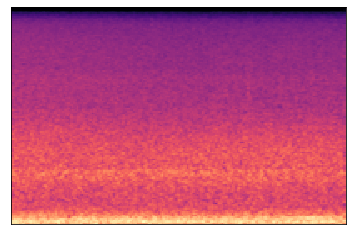

In [58]:
rand_npy = random.choice(list(trainSoundScapes.iterdir()))
rand_image = np.load(rand_npy)
print(f"rand_npy = {rand_npy.name}")
librosa.display.specshow(rand_image);

### Objective 2: Construct `df_train_soundscape`

Recall that
> - We want to update `df_train_soundscape` to contain more information. What information?
>   - Date: Can be separated.
>   - Corresponding `.npy` path: Can be separated.
>   - Longitude, latitude: Can be separated.
>   - birds label to birds indices?
>   - new col `"n_birds"` and do a stat?

Construct a dictionary for

- key: recording location, e.g. `COR`, `SSW`, etc.
- value: possibly `NamedTuple(longitude, latitude)`

In [59]:
from collections import namedtuple
Coordinate = namedtuple("Coordinate", ["longitude", "latitude"])

D_location_coordinate = dict()
for p in (PATH_DATASET / "test_soundscapes").glob("*_recording_location.txt"):
    location = p.stem.split("_")[0]
    with open(p) as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("Latitude:"):
                latitude = float(line.split(" ")[1])
            if line.startswith("Longitude:"):
                longitude = float(line.split(" ")[1])
    D_location_coordinate[location] = Coordinate(longitude=longitude, latitude=latitude)
D_location_coordinate

{'COL': Coordinate(longitude=-75.85, latitude=5.57),
 'COR': Coordinate(longitude=-84.51, latitude=10.12),
 'SNE': Coordinate(longitude=-119.95, latitude=38.49),
 'SSW': Coordinate(longitude=-76.45, latitude=42.47)}

In [73]:
df_train_soundscape.loc[is_train, ["row_id", "npy_path"]]

,row_id,npy_path
240,11254_COR_5,trainSoundScapes/11254_COR_5.npy
241,11254_COR_10,trainSoundScapes/11254_COR_10.npy
242,11254_COR_15,trainSoundScapes/11254_COR_15.npy
243,11254_COR_20,trainSoundScapes/11254_COR_20.npy
244,11254_COR_25,trainSoundScapes/11254_COR_25.npy
...,...,...
2395,54955_SSW_580,trainSoundScapes/54955_SSW_580.npy
2396,54955_SSW_585,trainSoundScapes/54955_SSW_585.npy
2397,54955_SSW_590,trainSoundScapes/54955_SSW_590.npy
2398,54955_SSW_595,trainSoundScapes/54955_SSW_595.npy


For the columns `"longitude", "latitude"`, we will loop thru `D_location_coordinate`.

In [74]:
D_location_coordinate

{'COL': Coordinate(longitude=-75.85, latitude=5.57),
 'COR': Coordinate(longitude=-84.51, latitude=10.12),
 'SNE': Coordinate(longitude=-119.95, latitude=38.49),
 'SSW': Coordinate(longitude=-76.45, latitude=42.47)}

In [88]:
def birds_to_ndarry(series):
    I = np.eye(len(D_label_index))
    ndarray = np.zeros((len(series), len(D_label_index)))
    for i, string in enumerate(series.values):
        if string == "nocall":
            continue
        else:
            L_indices = [D_label_index[label] for label in string.split(" ")]
            row_i = np.sum(I[L_indices], axis=0)
            ndarray[i] = row_i
    return ndarray

In [89]:
A = birds_to_ndarry(df_train_soundscape.birds)
A.shape

(2400, 397)

In [90]:
y_train = A[df_train_soundscape.is_test==False]
y_train.shape

(1920, 397)

In [91]:
y_test = A[df_train_soundscape.is_test==True]
y_test.shape

(480, 397)

In [92]:
df_train_soundscape

,row_id,site,audio_id,seconds,birds,is_test,year,month,day,longitude,latitude,npy_parent,npy_path
0,7019_COR_5,COR,7019,5,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_5.npy
1,7019_COR_10,COR,7019,10,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_10.npy
2,7019_COR_15,COR,7019,15,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_15.npy
3,7019_COR_20,COR,7019,20,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_20.npy
4,7019_COR_25,COR,7019,25,nocall,True,2019,9,4,-84.51,10.12,testSoundScapes,testSoundScapes/7019_COR_25.npy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,False,2017,6,17,-76.45,42.47,trainSoundScapes,trainSoundScapes/54955_SSW_580.npy
2396,54955_SSW_585,SSW,54955,585,grycat,False,2017,6,17,-76.45,42.47,trainSoundScapes,trainSoundScapes/54955_SSW_585.npy
2397,54955_SSW_590,SSW,54955,590,grycat,False,2017,6,17,-76.45,42.47,trainSoundScapes,trainSoundScapes/54955_SSW_590.npy
2398,54955_SSW_595,SSW,54955,595,nocall,False,2017,6,17,-76.45,42.47,trainSoundScapes,trainSoundScapes/54955_SSW_595.npy
